## Regresión

Para el problema de pronóstico, elegimos el dataset de [Air Pollution Forecasting](https://www.kaggle.com/datasets/rupakroy/lstm-datasets-multivariate-univariate?resource=download)

Este conjunto de datos informa sobre el clima y el nivel de contaminación cada hora durante cinco años en la embajada de Estados Unidos en Pekín, China.

Los datos incluyen la fecha y la hora, la concentración de PM2.5 y la información meteorológica, como el punto de rocío, la temperatura, la presión, la dirección y la velocidad del viento, y el número acumulado de horas de nieve y lluvia. El objetivo es predecir el nivel de contaminación de aire, que es el PM2.5

La lista completa de características de los datos es la siguiente:

- `date`: La fecha del registro (es por hora)
- `pollution`: concentración de PM2.5 (variable objetivo)
- `dew`: punto de rocío
- `temp`: temperatura
- `press`: presión
- `wnd_dir`: dirección del viento combinada
- `wnd_spd`: velocidad del viento acumulada
- `snow`: horas de nieve acumuladas
- `rain`: horas de lluvia acumuladas

Nuestro flujo de trabajo será el siguiente:
+ EDA
+ Entrenamiento y selección de un modelo de pronóstico lineal clásico para el caso univariado
+ Evaluación del modelo clásico
+ Selección, entrenamiento y validación de distintos modelos basados en redes neuronales en el caso univariado
+ Selección, entrenamiento y validación de distintos modelos basados en redes neuronales en el caso multivariado
+ Comparación de los modelos de redes neuronales univariados vs los multivariados
+ Comparación del modelo clásico univariado contra las redes neuronales univariadas
+ Selección del mejor modelo general y optimizarlo con `Optuna`

Para el registro y comparación de modelos usaremos MLFlow

#### Cargar los datos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler, MinMaxScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
from scipy.stats import boxcox
import statsmodels as st
from statsmodels.tsa.seasonal import MSTL
from sklearn.preprocessing import power_transform
from scipy.special import inv_boxcox
import scipy.stats as stats
import dagshub
import mlflow
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from python_files.LinearForecast import LinearForecast
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
df = pd.read_csv("data/Regression/LSTM-Multivariate_pollution.csv")
df.shape

(43800, 9)

### EDA

In [3]:
df.head()

,date,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
0,2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
1,2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2,2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
3,2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
4,2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


In [4]:
def reporte(df):
    dtyp = pd.DataFrame(df.dtypes, columns=['Tipo'])
    missing = pd.DataFrame(df.isnull().sum(), columns=['Valores_Nulos'])
    unival = pd.DataFrame(df.nunique(), columns=['Valores_Unicos'])
    maximo = pd.DataFrame(df.max(), columns=['Max'])
    minimo = pd.DataFrame(df.min(), columns=['Min'])
    return dtyp.join(missing).join(unival).join(maximo).join(minimo)

reporte(df)

,Tipo,Valores_Nulos,Valores_Unicos,Max,Min
date,object,0,43800,2014-12-31 23:00:00,2010-01-02 00:00:00
pollution,float64,0,581,994.0,0.0
dew,int64,0,69,28,-40
temp,float64,0,64,42.0,-19.0
press,float64,0,60,1046.0,991.0
wnd_dir,object,0,4,cv,NE
wnd_spd,float64,0,2788,585.6,0.45
snow,int64,0,28,27,0
rain,int64,0,37,36,0


Podemos ver que los datos recolectados son desde el 2do de enero de 2010 hasta el 31 de diciembre de 2014. No hay datos nulos en ninguna de nuestras variables. Vamos a convertir nuestra columna date a datetime

In [5]:
df['date'] = pd.to_datetime(df['date'])

In [6]:
#Calculo de estadísticos básicos.
# Algunas utilerías que vamos a usar
def autolabel(rects, ax):
    """
    Método auxiliar para agregarle el númerito correspondiente a su valor
    a la barra en una gráfica de barras.

    Esta función no la hice yo (aunque sí la modifiqué). La origi está en:
    https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/barchart.html

    rects: La figura de la gráfica guardada en una variable
    ax: El eje donde se está graficando.
    """
    # attach some text labels
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2.,
                1.05*height,
                '%d'%int(height),
                ha='center', va='bottom')

def _get_colors_to_use(variables):
    """ Función para asignarle colores crecientes a una lista de elements

    Parámetros
    ----------
    variables: Lista de elementos a los cuales les queremos asignar color


    Regresa
    -------
    Dictionario de la forma: {element: color}
    """
    colors = plt.cm.jet(np.linspace(0, 1, len(variables)))
    return dict(zip(variables, colors))


def plot_numeric(df, numeric_stats):

    metrics = ['mean', 'median', 'std', 'q25', 'q75', 'nulls']
    colors = _get_colors_to_use(metrics)

    for index, variable in enumerate(sorted(numeric_stats.keys())):

        # Plotting basic metrics
        fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))

        bar_position = -1
        for metric, value in numeric_stats[variable].items():
            bar_position += 1

            if value is None or np.isnan(value):
                value = -1

            # Plotting bars
            bar_plot = ax[0].bar(bar_position, value,
                                 label=metric, color=colors[metric])
            autolabel(bar_plot, ax[0])

            # Plotting histogram
            df[variable].plot(kind='hist', color='blue',
                              alpha=0.4, ax=ax[1])

            # Plotting boxplot
            df.boxplot(ax=ax[2], column=variable)

            ax[0].set_xticks(range(len(metrics)))
            ax[0].set_xticklabels(metrics, rotation=90)
            ax[2].set_xticklabels('', rotation=90)

            ax[0].set_title('\n Basic metrics \n', fontsize=10)
            ax[1].set_title('\n Data histogram \n', fontsize=10)
            ax[2].set_title('\n Data boxplot \n', fontsize=10)
            fig.suptitle(f'Variable: {variable} \n\n\n', fontsize=15)

            fig.tight_layout()
    return


def plot_categorical(df, object_stats):

    metrics = ['unique_vals', 'mode', 'null_count']
    colors = _get_colors_to_use(metrics)

    for index, variable in enumerate(sorted(object_stats.keys())):

        # Plotting basic metrics
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

        bar_position = -1
        for metric, value in object_stats[variable].items():
            bar_position += 1

            if metric == 'mode':
                mode = value[0]
                value = value[1]

            if value is None or np.isnan(value):
                value = -1

            bar_plot = ax.bar(bar_position, value,
                              label=metric, color=colors[metric])
            autolabel(bar_plot, ax)

        ax.set_xticks(range(len(metrics)))
        ax.set_xticklabels(metrics, rotation=90, fontsize=15)

        ax.set_title(
            f'\n Basic object metrics: {variable} \n Mode: {mode}\n',
            fontsize=15)

        fig.tight_layout()
    return

def get_numeric_stats(df):
    """
    Esta magia sacará estadísticas básicas DE LAS VARIABLES NUMÉRICAS.

    Parámetros
    ----------
    df: pandas.DataFrame
        Tabla con variables limpias.

    Regresa
    -------
    stats: diccionario
        Dict de la forma {columna: {nombre de la métrica: valor de la métrica}}
    """
    # Seleccionando las variables numéricas únicamente
    numeric_df = df.select_dtypes(include=['float64', 'int64'])

    # Este va a ser el diccionario que regresaremos, lo llenaremos con un looop.
    stats = {}

    # Recorramos las columnas
    for numeric_column in numeric_df.columns:
        # Obtengamos el promedio
        mean = numeric_df[numeric_column].mean()

        # Ahora la mediana
        median = numeric_df[numeric_column].median()

        # Ahora la desviación estándar
        std = numeric_df[numeric_column].std()

        # Obtengamos el primer y tercer cuartil
        quantile25, quantile75 = numeric_df[numeric_column].quantile(
            q=[0.25, 0.75])

        # ¿Cuál es el porcentaje de nulos?
        null_count = 100 * (
        numeric_df[numeric_column].isnull().sum() / len(numeric_df))

        # Guardemos
        stats[numeric_column] = {'mean': mean,
                                 'median': median,
                                 'std': std,
                                 'q25': quantile25,
                                 'q75': quantile75,
                                 'nulls': null_count
                                 }
    return stats

def get_cat_stats(df):
    """
    Esta magia sacará estadísticas básicas DE LAS VARIABLES CATEGÓRICAS

    Parámetros
    ----------
    df: pandas.DataFrame
        Tabla con variables limpias.

    Regresa
    -------
    stats: diccionario
        Dict de la forma {columna: {nombre de la métrica: valor de la métrica}}
    """
    # Seleccionando los objetos
    object_df = df.select_dtypes(include=['object', 'category'])

    # El dict que regresaremos
    stats = {}

    # Recorramos las columnas
    for object_column in object_df.columns:
        # ¿Cuántos valores únicos hay?
        unique_vals = len(object_df[object_column].unique())

        # Saquemos la "moda" (valor más común).
        # Para eso primero usamos value_counts para encontrar la frecuenc
        all_values = object_df[object_column].value_counts()

        # Ahora sacaremos una tupla con el valor más común y el porcentaje de veces
        # que aparece
        mode = (all_values.index[0],
                100 * (all_values.values[0] / len(object_df)))

        # Cuenta de nulos
        null_count = (object_df[object_column].isnull().sum() / len(
            object_df)) * 100

        # Stats a devolver
        stats[object_column] = {'unique_vals': unique_vals,
                                'mode': mode,
                                'null_count': null_count}

    return stats

In [7]:
# Seleccionar columnas que sean numéricas
numeric_cols = df.select_dtypes(include=['int64', 'float64'])
numeric_df = df[numeric_cols.columns]

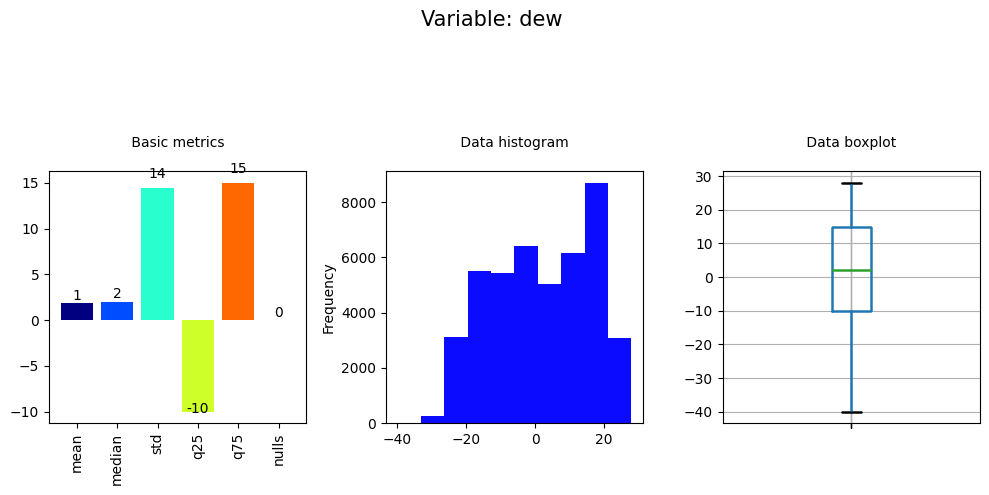

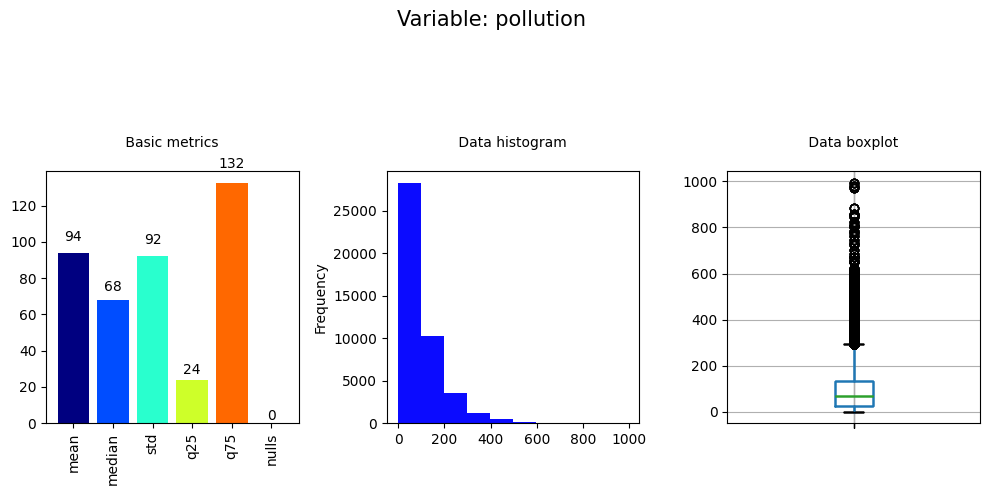

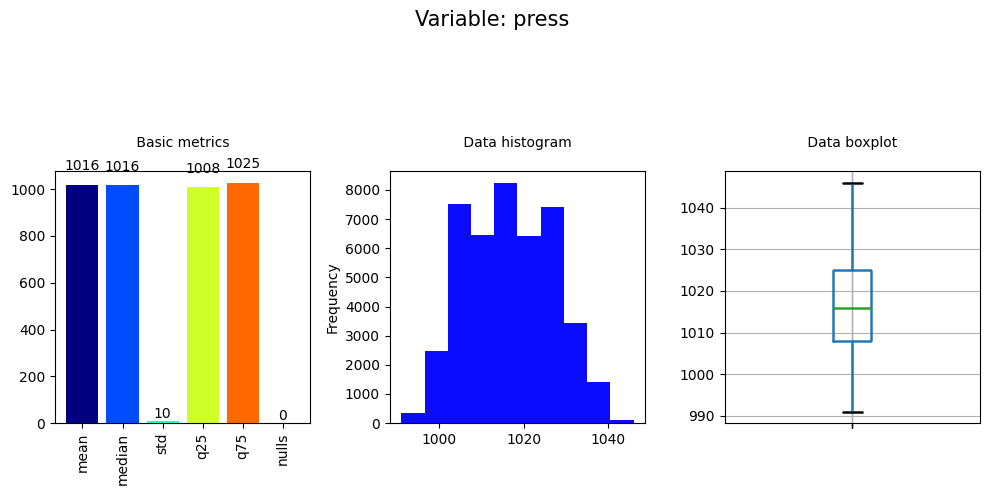

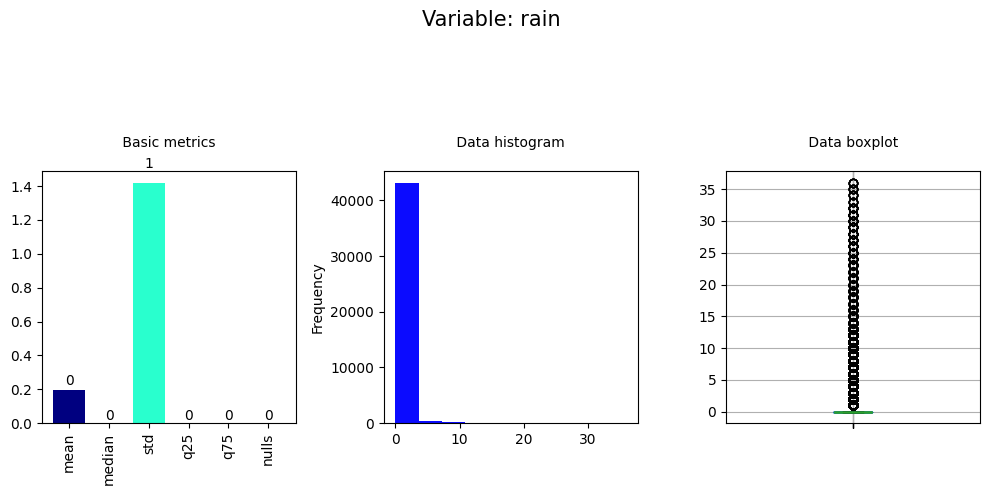

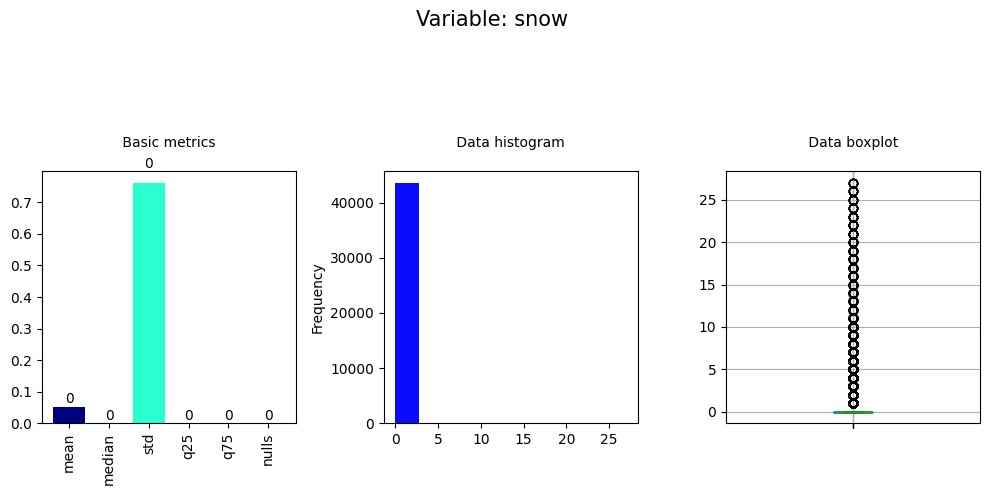

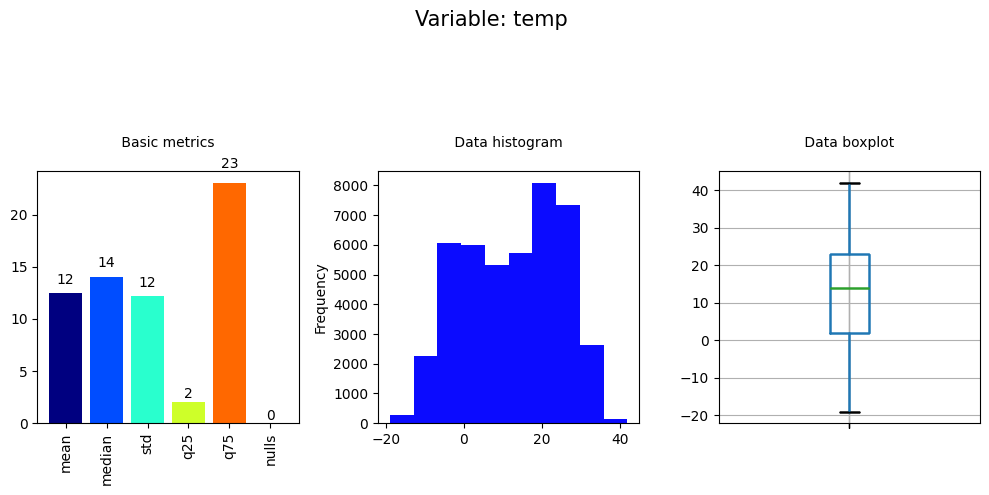

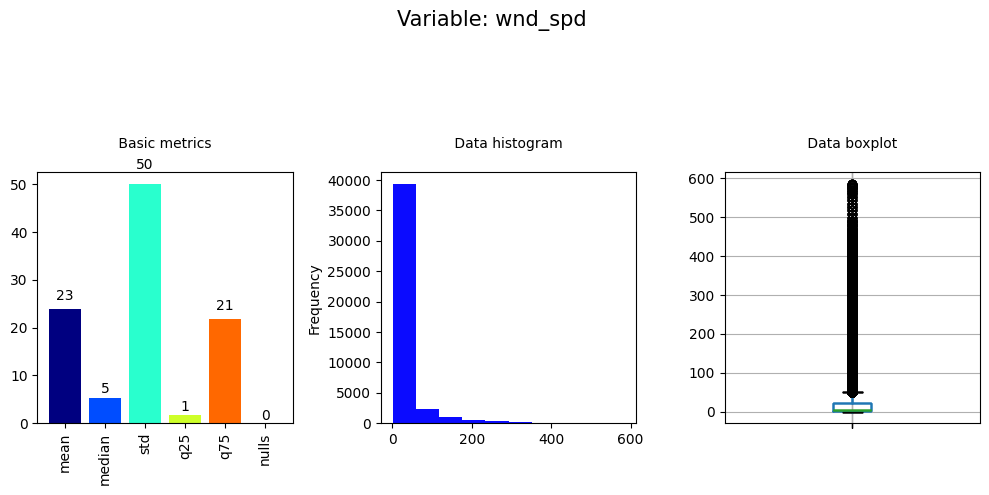

In [8]:
#Variables numéricas.
numeric_stats = get_numeric_stats(numeric_df)   
plot_numeric(df, numeric_stats)

En las gráficas de estadísticas básicas, podemos ver lo siguiente:
+ `dew`: No tiene datos atípicos y su distribución no está muy anormal
+ `pollution`: Contiene varios datos atípicos, su promedio es de 94 y los valores suelen acotarse entre 24 y 132
+ `press`: No hay datos atípicos y la distribución parece acercarse a la normal, los valores son muy similares entre sí
+ `rain`: El promedio es de 0 y hay bastantes atípicos
+ `snow`: Al igual que la variable de lluvia, su promedio es 0 y hay muchos atípicos, esto no debe alarmar ya que son las horas acumuladas de nieve/lluvia
+ `temp`: No hay atípicos y su distribución parece ser normal, el promedio es de 14
+ `wnd_spd`: Hay bastantes atípicos y la desviación estándar es muy alta, igual no hay que alarmarse ya que es la velocidad del viento acumulada

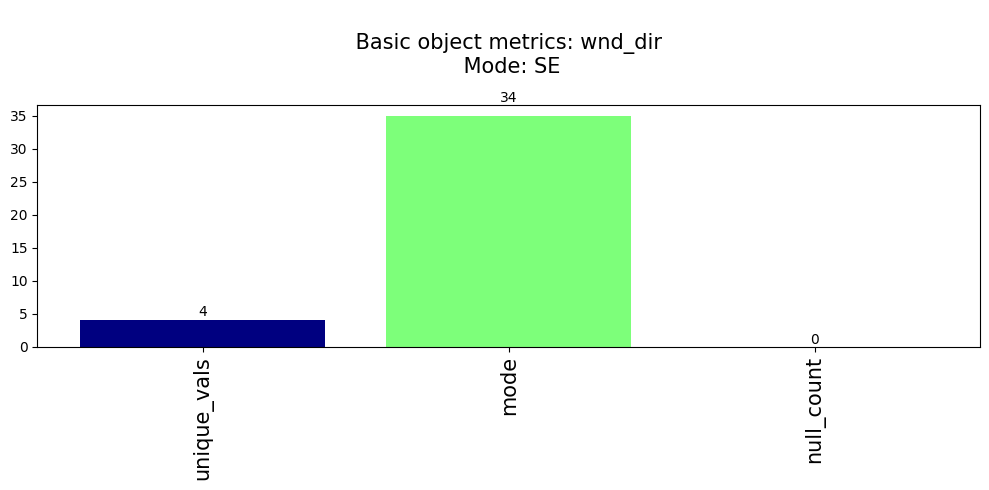

In [9]:
#Variables categóricas.
object_cols = df.select_dtypes(include=['object', 'category'])
object_df = object_cols.loc[:, ~object_cols.columns.str.contains('date', case=False)]
cat_stats = get_cat_stats(object_df)
plot_categorical(df, cat_stats)

Aquí podemos ver que la variable `wnd_dir` tiene 4 posibles valores y la moda es SE, indicando South-East.

In [10]:
df_codificado = df.copy()

In [11]:
def label_encode_variables_categoricas(df_codificado):
    # Selecciona las columnas de tipo objeto (categóricas)
    columnas_objeto = df_codificado.select_dtypes(include=['object']).columns

    # Inicializa el codificador
    label_encoder = LabelEncoder()

    # Itera sobre las columnas seleccionadas y aplica el label encoding
    for columna in columnas_objeto:
        df_codificado[columna] = label_encoder.fit_transform(df_codificado[columna])

    return df_codificado

df_para_corr = label_encode_variables_categoricas(df_codificado)

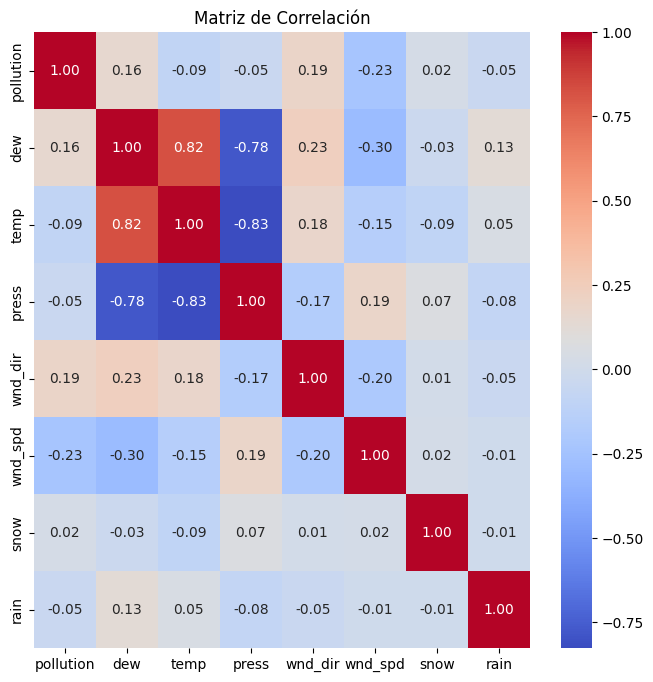

In [12]:
# Calcula la matriz de correlación excluyendo la columna date
matriz_correlacion = df_para_corr.drop('date', axis=1).corr()

# Configura el tamaño de la figura
plt.figure(figsize=(8, 8))

# Genera la matriz de correlación con Seaborn
sns.heatmap(matriz_correlacion, annot=True, cmap='coolwarm', fmt=".2f")

# Añade título
plt.title('Matriz de Correlación')

# Muestra la matriz de correlación
plt.show()

Matriz de correlaciones:
1. Relaciones positivas fuertes
    + `temp` y `dew` tienen una correlación positiva de 0.82
2. Relaciones negativas fuertes
    + `press` y `dew` tienen una correlación negativa de -0.78, `press` y `temp` de -0.83

Las demás variables no muestran fuerte correlación con la siguiente más correlacionada siendo `dew` y `wnd_spd` con -0.30 

#### Análisis univariado para SARIMAX

In [13]:
# Convert date column to datetime if it isn't already
df['date'] = pd.to_datetime(df['date'])

# Create time series with date as index and pollution as values
time_series = df.set_index('date')['pollution']
time_series = pd.DataFrame(time_series)
time_series = time_series.rename(columns={'pollution': 'y'})
time_series.head()

,y
date,
2010-01-02 00:00:00,129.0
2010-01-02 01:00:00,148.0
2010-01-02 02:00:00,159.0
2010-01-02 03:00:00,181.0
2010-01-02 04:00:00,138.0


In [14]:
time_series.shape

(43800, 1)

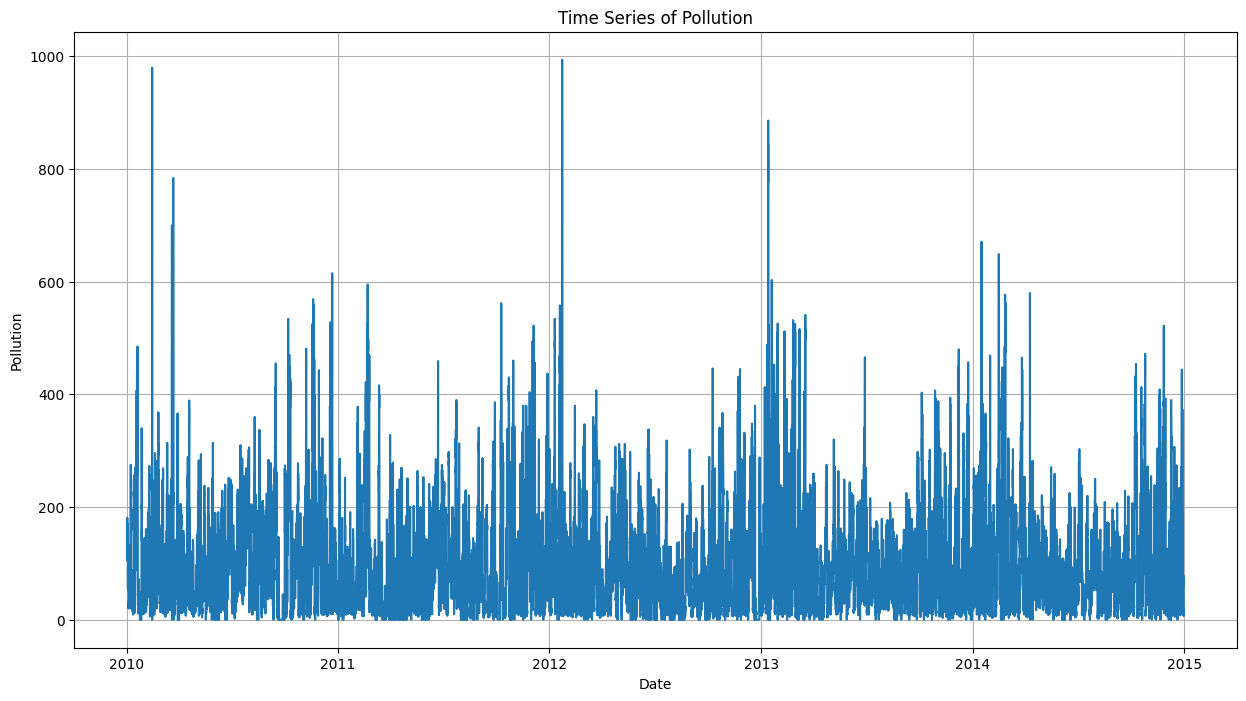

In [15]:
# Plot the time series
plt.figure(figsize=(15, 8))
plt.plot(time_series.index, time_series['y'])
plt.title('Time Series of Pollution')
plt.xlabel('Date')
plt.ylabel('Pollution')
plt.grid()
plt.show()

<Axes: >

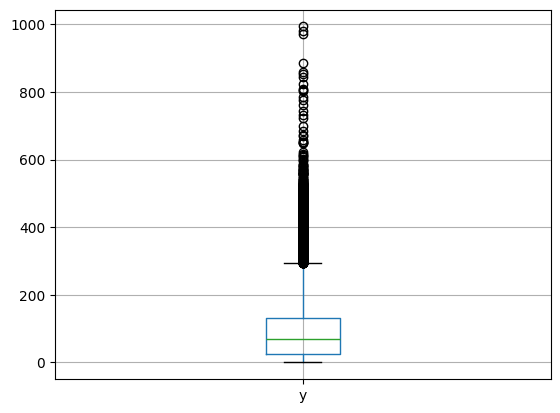

In [16]:
# Vamos a graficar el boxplot
time_series.boxplot()

In [17]:
# Detectar outliers con IQR
Q1 = time_series['y'].quantile(0.25)
Q3 = time_series['y'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = time_series[(time_series['y'] < lower_bound) | (time_series['y'] > upper_bound)]
print("Outliers detected:")
print(outliers)

Outliers detected:
                         y
date                      
2010-01-17 21:00:00  317.0
2010-01-17 23:00:00  313.0
2010-01-18 02:00:00  303.0
2010-01-18 03:00:00  349.0
2010-01-18 04:00:00  407.0
...                    ...
2014-12-29 00:00:00  362.0
2014-12-29 01:00:00  372.0
2014-12-29 02:00:00  373.0
2014-12-29 03:00:00  372.0
2014-12-29 04:00:00  318.0

[1878 rows x 1 columns]


In [18]:
reporte(outliers)

,Tipo,Valores_Nulos,Valores_Unicos,Max,Min
y,float64,0,286,994.0,295.0


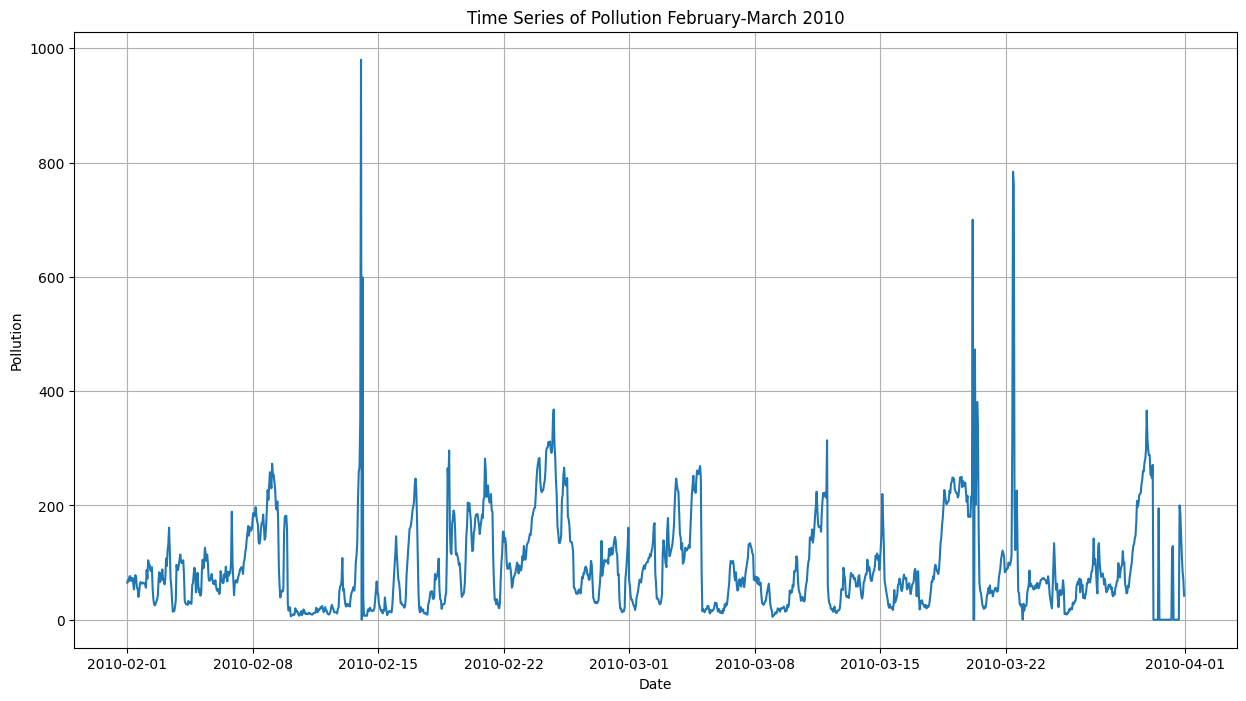

In [19]:
# Filter time series for 2010-2011
time_series_2010_2011 = time_series['2010-02':'2010-03']

# Plot the filtered time series
plt.figure(figsize=(15, 8))
plt.plot(time_series_2010_2011.index, time_series_2010_2011['y'])
plt.title('Time Series of Pollution February-March 2010')
plt.xlabel('Date') 
plt.ylabel('Pollution')
plt.grid()
plt.show()


Al graficar y analizar la variable de interés, nos encontramos con varios datos atípicos, primero en el boxplot y después con el método del rango intercuartil. De los 43,800 registros que tenemos, nos marca 1,878 atípicos. Al ver una muestra de los que marca como atípicos, vemos valores superiores a 300. Al usar nuestra función de reporte, vemos que alcanzan máximos de hasta 994.

Después de una breve investigación, encontramos que la página oficial de calidad del aire de Estados Unidos, AirNow, tiene los siguientes rangos de calidad:

![Air Quality Table](images/Air_pollution_table.png)

Con esta información, podría parecer que son errores de medición, sin embargo, valores de más de 300 pueden ser totalmentes posibles, ya que graficamos una parte en donde se encuentran estos valores atípicos, y parece que los días siguientes al atípico siguen siendo valores grandes, entonces no son ni errores de medición ni imposibles. Es por esto que decidimos dejarlos.

AQI Basics | AirNow.gov. (n.d.). https://www.airnow.gov/aqi/aqi-basics/

In [20]:
# Dividir los datos en entrenamiento y prueba
n_train = int(0.75 * len(time_series))
train_data = time_series[:n_train]
n_test = len(time_series) - n_train
test_data = time_series[-n_test:]

In [21]:
lf = LinearForecast(data=train_data)

In [22]:
lf.adf_test() # Estacionariedad de los datos originales
# Vamos a visualizar todas las transformaciones para luego decidir cuál será la elegida

Results of Dickey-Fuller Test:
Test Statistic                -1.812484e+01
p-value                        2.515619e-30
#Lags Used                     5.200000e+01
Number of Observations Used    3.279700e+04
Critical Value (1%)           -3.430549e+00
Critical Value (5%)           -2.861628e+00
Critical Value (10%)          -2.566817e+00
dtype: float64
Stationary


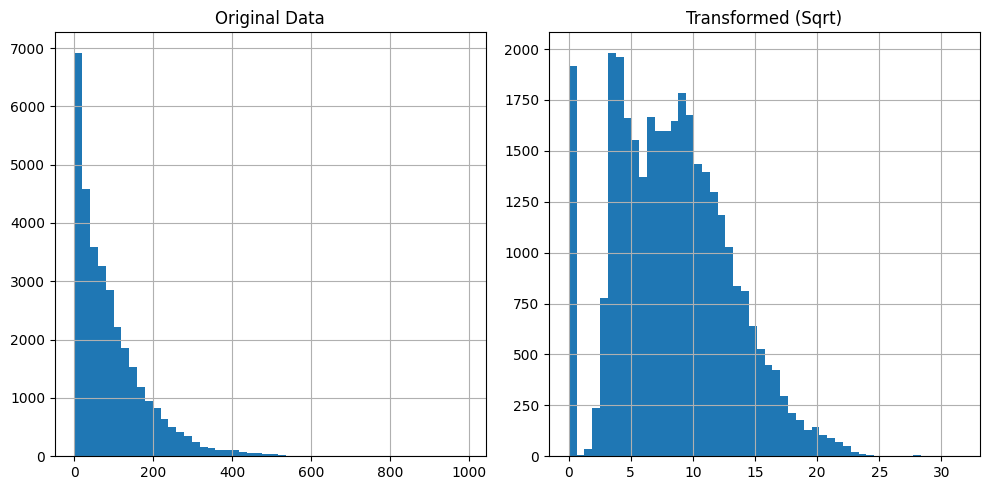

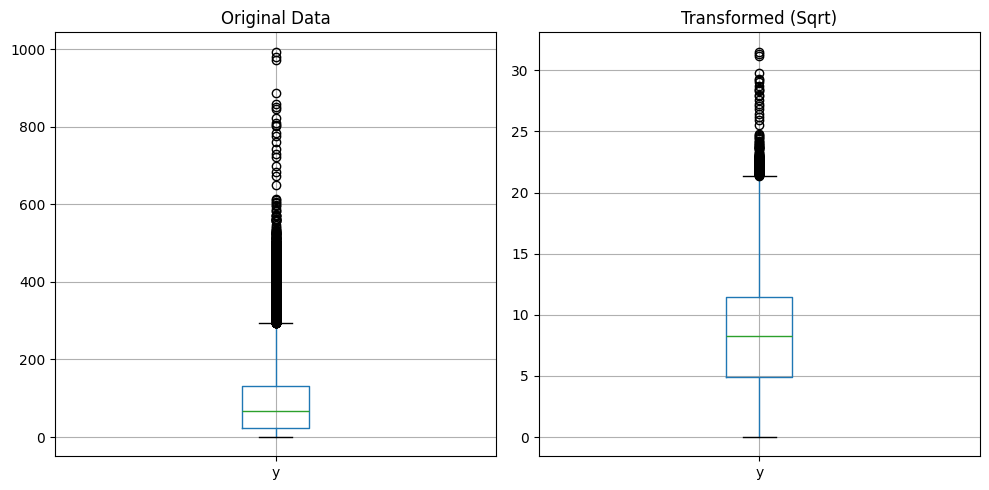

In [23]:
lf.timeseries_transformation(transformation="sqrt")

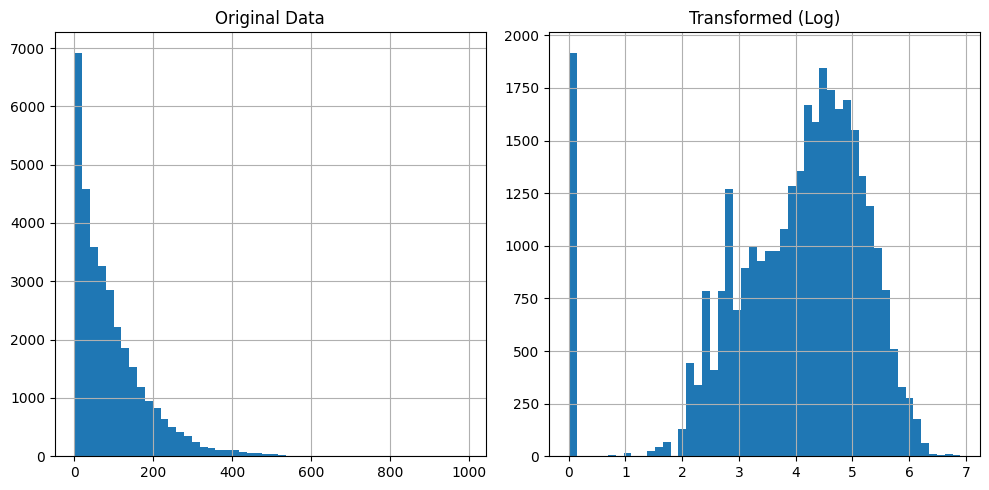

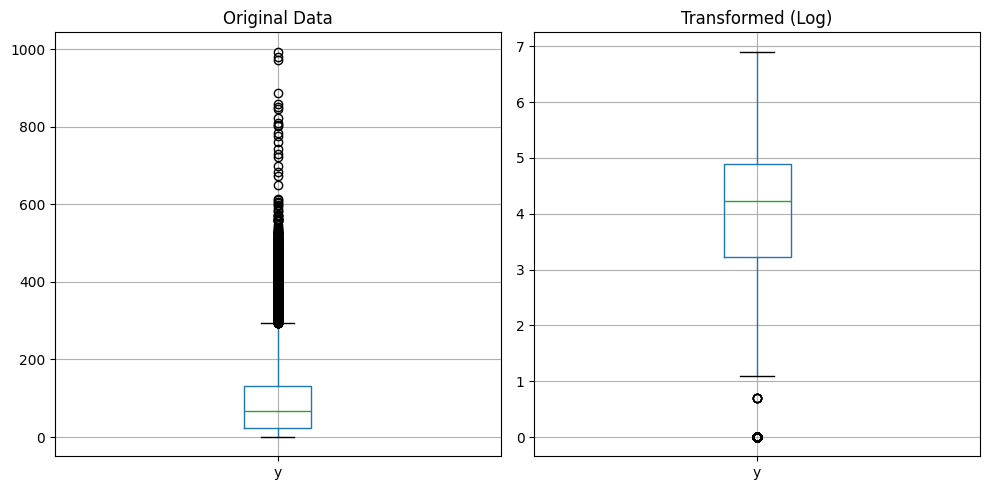

In [24]:
lf.timeseries_transformation(transformation="log")

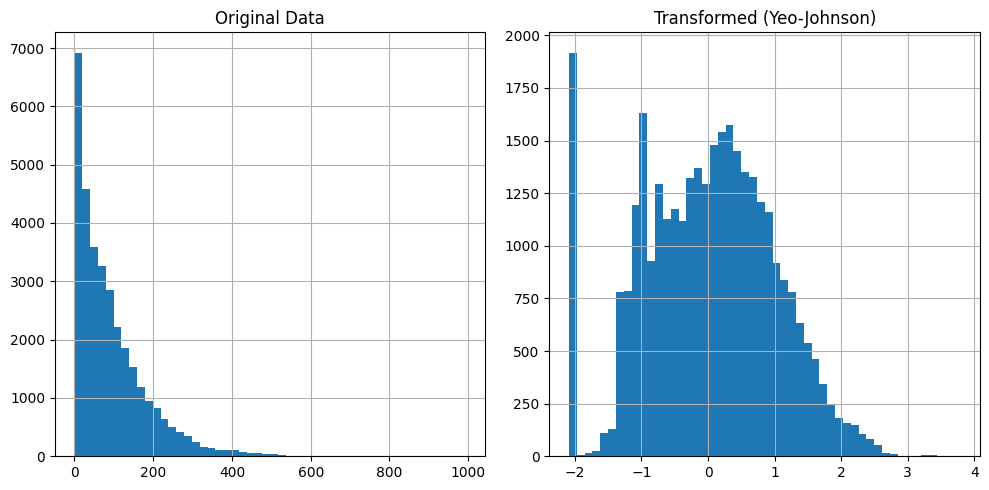

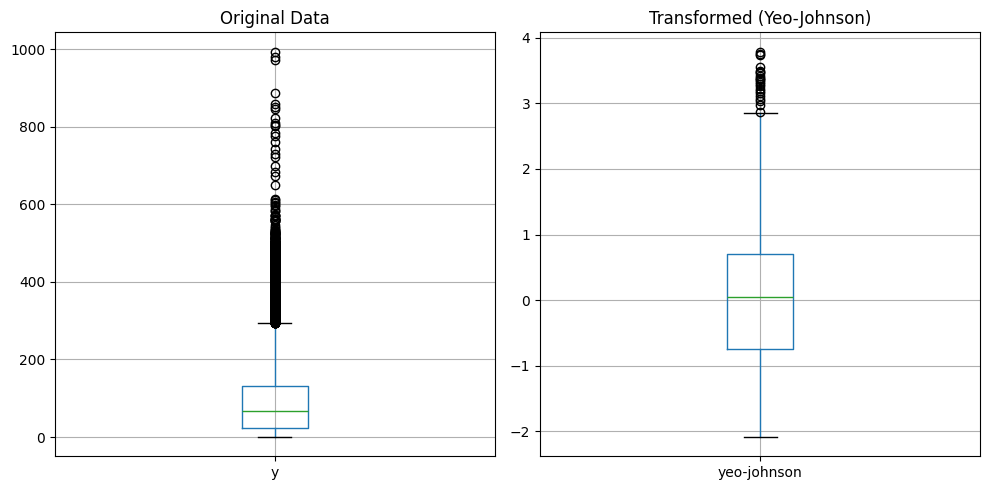

In [25]:
lf.timeseries_transformation(transformation="yeo-johnson")

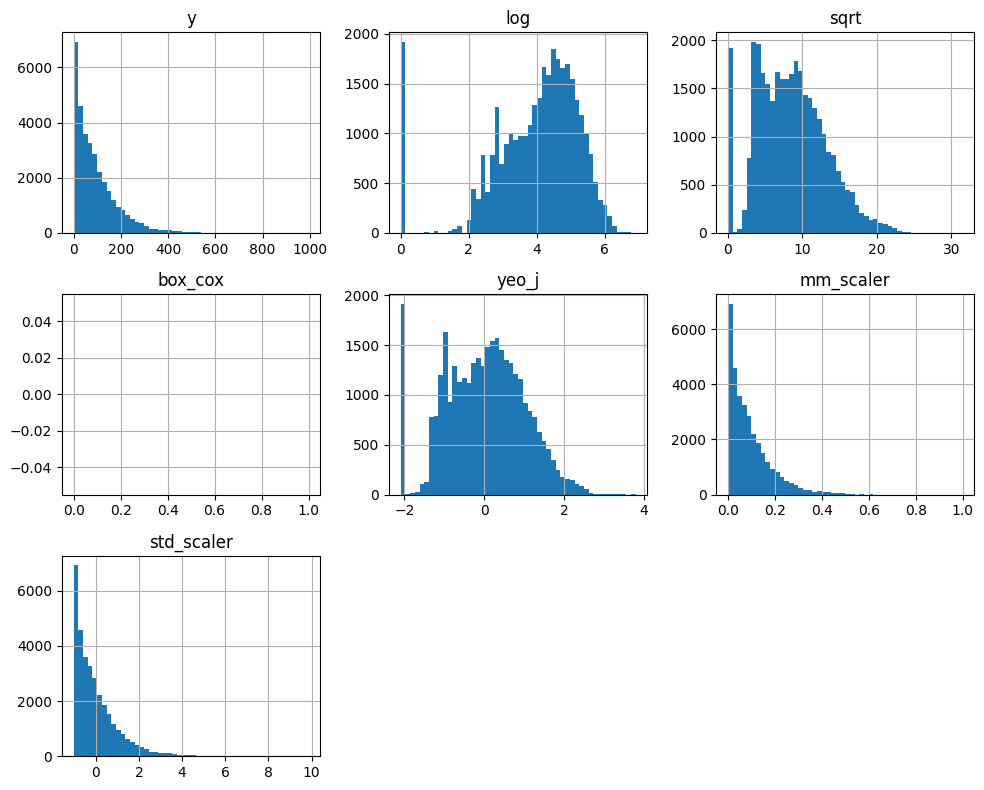

,y,log,sqrt,box_cox,yeo_j,mm_scaler,std_scaler
date,,,,,,,
2010-01-02 00:00:00,129.0,4.867534,11.357817,NaN,0.679100,0.129779,0.392923
2010-01-02 01:00:00,148.0,5.003946,12.165525,NaN,0.832137,0.148893,0.600763
2010-01-02 02:00:00,159.0,5.075174,12.609520,NaN,0.914642,0.159960,0.721092
2010-01-02 03:00:00,181.0,5.204007,13.453624,NaN,1.068560,0.182093,0.961749
2010-01-02 04:00:00,138.0,4.934474,11.747340,NaN,0.753393,0.138833,0.491374


In [26]:
train, lambda_value = lf.consolidated_ts_df(data=train_data, plot_graphs=True)
train.head()

Después de ver los resultados de las transformaciones, elegiremos la de yeo-johnson. La segunda mejor fue la de log, sin embargo, como hay valores que son 0 en nuestra serie (misma razón por la cuál no aplicó box-cox), la de yeo-johnson es mejor.

In [27]:
train.drop([col for col in train.columns if 'yeo_j' not in col], axis=1, inplace=True)
train.rename(columns={'yeo_j': 'y'}, inplace=True)

In [28]:
lf = LinearForecast(data=train)

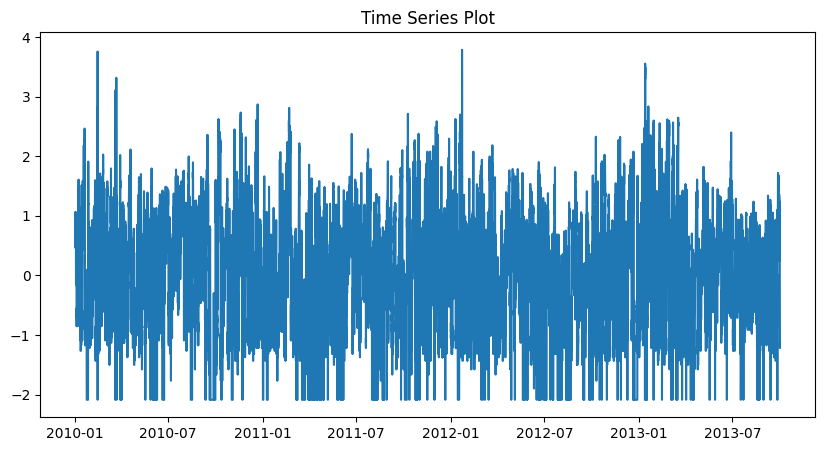

In [29]:
lf.plot_time_series()

Ahora evaluaremos la estacionariedad con la prueba de ADF y la descomposición para analizar los componentes.

In [30]:
lf.adf_test()

Results of Dickey-Fuller Test:
Test Statistic                -1.805301e+01
p-value                        2.635913e-30
#Lags Used                     5.100000e+01
Number of Observations Used    3.279800e+04
Critical Value (1%)           -3.430549e+00
Critical Value (5%)           -2.861628e+00
Critical Value (10%)          -2.566817e+00
dtype: float64
Stationary


In [31]:
def mstl_descomposition1(data, periods_seasonality, stl_kwargs=None):
    """
    Perform MSTL decomposition to identify trend, seasonal, and residual components of a time series.

    Parameters:
        periods_seasonality (list): List of seasonal periods to be considered.
        stl_kwargs (dict, optional): Additional keyword arguments for STL decomposition.

    Returns:
        DecomposeResult: A result object that includes trend, seasonal components, and residuals.
    """
    if stl_kwargs is None:
        stl_kwargs = {}

    if data is None or data.empty:
        raise ValueError("The data parameter is empty or None.")

    y = data['y']
    mstl = MSTL(endog=y, periods=periods_seasonality, **stl_kwargs)
    result = mstl.fit()

    return result

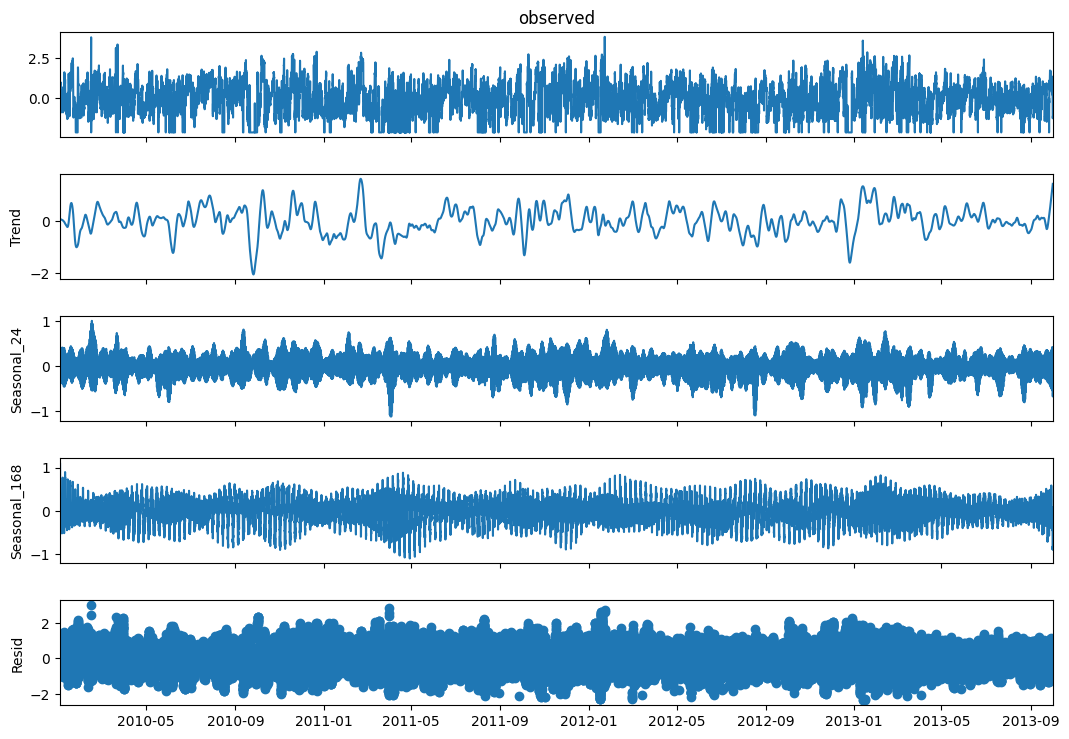

In [32]:
res = mstl_descomposition1(train,periods_seasonality=[24, 168]) # 24 por ser diario, 168 semanal
res.plot().set_size_inches(12, 8)
plt.show()

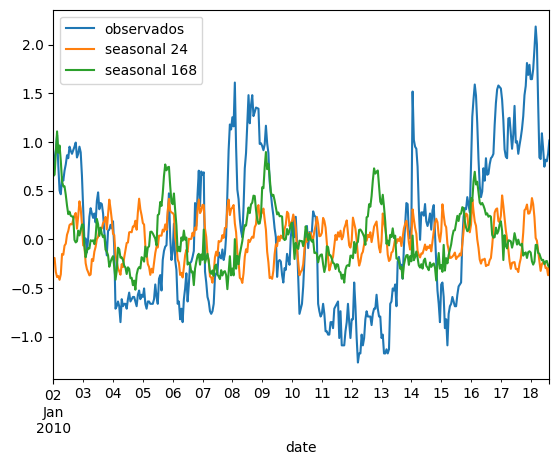

In [33]:
# Graficar datos observados con datos de estacionalidad
ax = res.observed[:400].plot(label='observados')

res.seasonal['seasonal_24'][:400].plot(ax=ax, label='seasonal 24')
res.seasonal['seasonal_168'][:400].plot(ax=ax, label='seasonal 168')

plt.legend()
plt.show()

##### Estacionariedad de la estacionalidad encontrada

In [34]:
# En base a la estacionalidad seleccionada, calcular la estacionariedad de dicha serie temporal
seasonality_24 = res.seasonal['seasonal_24']

lf.adf_test(seasonality_24)

Results of Dickey-Fuller Test:
Test Statistic                   -44.053653
p-value                            0.000000
#Lags Used                        52.000000
Number of Observations Used    32797.000000
Critical Value (1%)               -3.430549
Critical Value (5%)               -2.861628
Critical Value (10%)              -2.566817
dtype: float64
Stationary


In [35]:
# Estacionariedad de la segunda parte estacional
seasonality_168 = res.seasonal['seasonal_168']

lf.adf_test(seasonality_168)

Results of Dickey-Fuller Test:
Test Statistic                   -26.059571
p-value                            0.000000
#Lags Used                        51.000000
Number of Observations Used    32798.000000
Critical Value (1%)               -3.430549
Critical Value (5%)               -2.861628
Critical Value (10%)              -2.566817
dtype: float64
Stationary


In [36]:
trend_data = res.trend
resid_data = res.resid

In [37]:
lf.adf_test(trend_data) # Estacionariedad de la tendencia

Results of Dickey-Fuller Test:
Test Statistic                -8.902856e+00
p-value                        1.158723e-14
#Lags Used                     4.500000e+01
Number of Observations Used    3.280400e+04
Critical Value (1%)           -3.430549e+00
Critical Value (5%)           -2.861628e+00
Critical Value (10%)          -2.566817e+00
dtype: float64
Stationary


In [38]:
lf.adf_test(resid_data) # Estacionariedad de residuos

Results of Dickey-Fuller Test:
Test Statistic                   -25.814689
p-value                            0.000000
#Lags Used                        52.000000
Number of Observations Used    32797.000000
Critical Value (1%)               -3.430549
Critical Value (5%)               -2.861628
Critical Value (10%)              -2.566817
dtype: float64
Stationary


##### Genere los correlogramas ACF y PACF para evaluar patrones de autocorrelación.

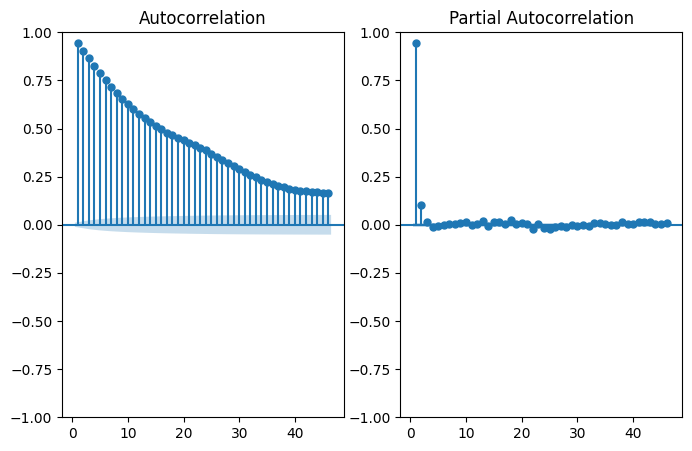

In [39]:
lf.plot_acf_pacf()

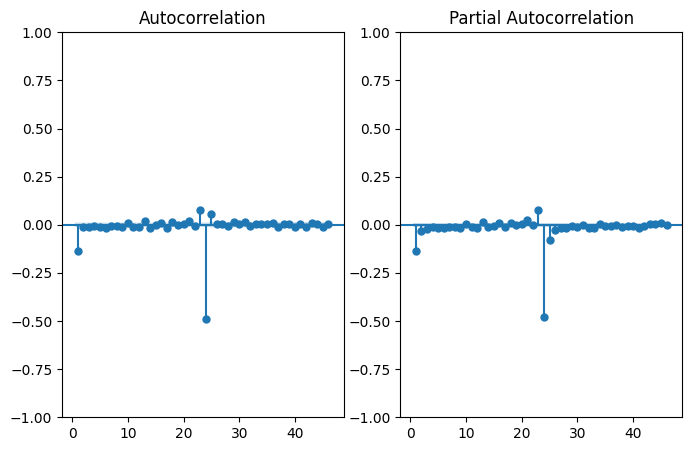

In [40]:
lf.plot_acf_pacf(data=train.diff().diff(24).dropna())

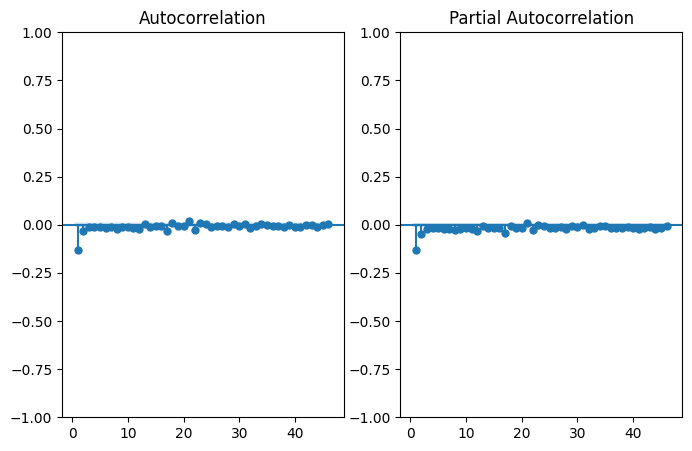

In [41]:
lf.plot_acf_pacf(data=train.diff().diff(168).dropna())

Basado en las gráficas, los posibles valores son:

P -> 1

D -> 1

Q -> 1

Ahora para el componenete no estacional

In [42]:
# Calcular la estacionariedad de mis datos observados
lf.adf_test(res.observed.dropna())

Results of Dickey-Fuller Test:
Test Statistic                -1.805301e+01
p-value                        2.635913e-30
#Lags Used                     5.100000e+01
Number of Observations Used    3.279800e+04
Critical Value (1%)           -3.430549e+00
Critical Value (5%)           -2.861628e+00
Critical Value (10%)          -2.566817e+00
dtype: float64
Stationary


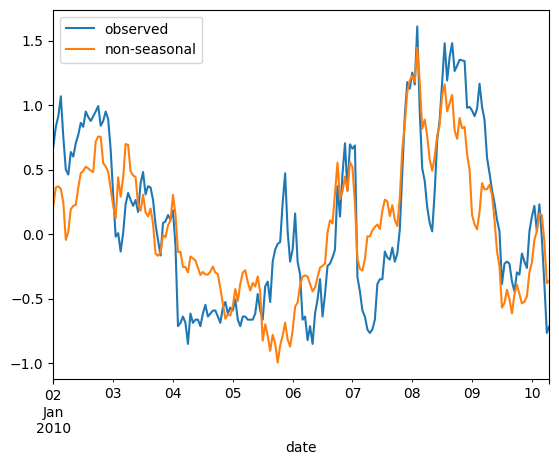

In [43]:
# Calcular la componente no estacional de la serie temporal basado en la S anterior
non_seasonal = res.observed - res.seasonal['seasonal_24'] - res.seasonal['seasonal_168'] 

res.observed[:200].plot()
non_seasonal[:200].plot()
plt.legend(['observed', 'non-seasonal'])

In [44]:
# Calcular si la serie no estacional es estacionaria o no
lf.adf_test(non_seasonal.dropna())

Results of Dickey-Fuller Test:
Test Statistic                -1.510651e+01
p-value                        7.805352e-28
#Lags Used                     5.200000e+01
Number of Observations Used    3.279700e+04
Critical Value (1%)           -3.430549e+00
Critical Value (5%)           -2.861628e+00
Critical Value (10%)          -2.566817e+00
dtype: float64
Stationary


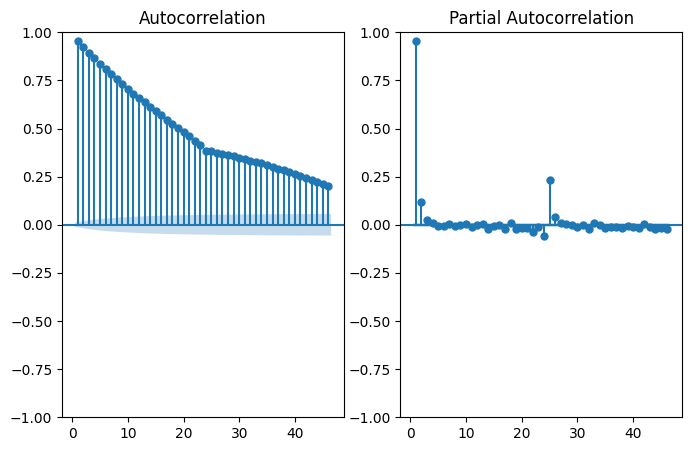

In [45]:
lf.plot_acf_pacf(non_seasonal.dropna())

Para los posibles valores son:

p -> 2

d -> 0

q -> 0

### SARIMAX

In [46]:
from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer(method='yeo-johnson')
# Transformar los datos de entrenamiento y prueba
train_transformed = pt.fit_transform(train_data.values.reshape(-1, 1))
test_transformed = pt.transform(test_data.values.reshape(-1, 1))

Vamos a loggear el experimento en MLFlow.

In [47]:
dagshub.init(url="https://dagshub.com/daduke1/proyecto-modelos", mlflow=True)

MLFLOW_TRACKING_URI = mlflow.get_tracking_uri()

print(MLFLOW_TRACKING_URI)

mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
mlflow.set_experiment(experiment_name="regresion")

Accessing as daduke1

Initialized MLflow to track repo "daduke1/proyecto-modelos"

Repository daduke1/proyecto-modelos initialized!

https://dagshub.com/daduke1/proyecto-modelos.mlflow


<Experiment: artifact_location='mlflow-artifacts:/15e9e4d7f3194c0580cd27a1d80f5cac', creation_time=1747164262903, experiment_id='2', last_update_time=1747164262903, lifecycle_stage='active', name='regresion', tags={}>

In [48]:
order = (2, 0, 0)
seasonal_order = (1, 1, 1, 24)

with mlflow.start_run() as run:
    # Log parameters
    mlflow.log_param("order", order)
    mlflow.log_param("seasonal_order", seasonal_order)

    # Fit model
    model = SARIMAX(train_transformed, order=order, seasonal_order=seasonal_order,
                    enforce_stationarity=False, enforce_invertibility=False)
    results = model.fit(disp=False)

    # Save model
    #model_file = "sarimax_model.pkl"
    #joblib.dump(results, model_file)
    #mlflow.log_artifact(model_file)

    # Forecast
    forecast_trans = results.forecast(steps=len(test_transformed))
    forecast_trans = pd.DataFrame(forecast_trans)
    forecast_inv = pt.inverse_transform(forecast_trans).flatten()

    # Compute and log metrics
    rmse = np.sqrt(mean_squared_error(test_data, forecast_inv))
    mse = mean_squared_error(test_data, forecast_inv)
    mape = mean_absolute_percentage_error(test_data, forecast_inv)
    r2 = r2_score(test_data, forecast_inv)

    mlflow.log_metric("RMSE_test", rmse)
    mlflow.log_metric("MSE_test", mse)
    mlflow.log_metric("MAPE_test", mape)
    mlflow.log_metric("R2_test", r2)

    # Log model summary
    summary_file = "results/sarimax/model_summary.txt"
    with open(summary_file, "w") as f:
        f.write(results.summary().as_text())
    mlflow.log_artifact(summary_file)

    # Plot forecast vs actual
    plt.figure(figsize=(10, 6))
    plt.plot(test_data.index, test_data, label="Actual")
    plt.plot(test_data.index, forecast_inv, label="Forecast", linestyle='--')
    plt.title("SARIMAX Forecast vs Actual (Test Set)")
    plt.legend()
    plt.tight_layout()
    plot_file = "results/forecast_vs_actual.png"
    plt.savefig(plot_file)
    plt.close()
    mlflow.log_artifact(plot_file)

    print(f"Logged SARIMAX model. RMSE: {rmse:.2f}, MAPE: {mape:.2%}, R²: {r2:.3f}")

Logged SARIMAX model. RMSE: 99.39, MAPE: 335023554262301760.00%, R²: -0.103
🏃 View run dashing-ant-978 at: https://dagshub.com/daduke1/proyecto-modelos.mlflow/#/experiments/2/runs/230acf3460204647b777d7ab5de875d7
🧪 View experiment at: https://dagshub.com/daduke1/proyecto-modelos.mlflow/#/experiments/2


El modelo SARIMAX dió las siguientes métricas:

+ RMSE: 99.39
+ MAPE: 335023554262301760.00%
+ R2: -0.103

### Redes Neuronal (univariado)

In [49]:
time_series.shape

(43800, 1)

In [50]:
def preprocess_univariate_series(
    df, 
    n_past=24, 
    n_future=1, 
    train_ratio=0.7, 
    val_ratio=0.15,
    scale=True,
    differencing=False
):
    """
    Prepares univariate time series for MLP/CNN/LSTM/ConvLSTM.
    
    Args:
        df (pd.DataFrame): DataFrame with datetime index and 'y' column.
        n_past (int): Lookback window (e.g., 24 hours).
        n_future (int): Forecast horizon (e.g., 1 for next step).
        train_ratio (float): Ratio of training data.
        val_ratio (float): Ratio of validation data.
        scale (bool): Whether to scale the data.
        differencing (bool): Whether to apply differencing.
    
    Returns:
        Dict: Processed data and metadata for all models.
              Keys: 'X_train', 'y_train', 'X_val', 'y_val', 'X_test', 'y_test',
                    'scaler', 'input_shape_mlp', 'input_shape_cnn', 
                    'input_shape_lstm', 'input_shape_convlstm'
    """
    # Extract values and handle NaNs
    series = df['y'].dropna().values.reshape(-1, 1)
    
    # Differencing (optional)
    if differencing:
        series = np.diff(series.flatten(), n=1).reshape(-1, 1)
    
    # Scaling (fit only on training data)
    scaler = RobustScaler() if scale else None
    if scale:
        train_size = int(len(series) * train_ratio)
        scaler.fit(series[:train_size])
        series = scaler.transform(series)
    
    # Generate input-output pairs
    X, y = [], []
    for i in range(n_past, len(series) - n_future + 1):
        X.append(series[i-n_past:i, 0])
        y.append(series[i:i+n_future, 0])
    X, y = np.array(X), np.array(y)
    
    # Split into train/val/test
    train_size = int(len(X) * train_ratio)
    val_size = int(len(X) * val_ratio)
    
    X_train, y_train = X[:train_size], y[:train_size]
    X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
    X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]
    
    # Define input shapes for each model type
    input_shape_mlp = (n_past,)          # MLP: (timesteps,)
    input_shape_cnn = (n_past, 1)        # CNN: (timesteps, features)
    input_shape_lstm = (n_past, 1)       # LSTM: (timesteps, features)
    input_shape_convlstm = (1, n_past, 1)  # ConvLSTM: (samples, timesteps, features, channels)
    
    # Reshape X for each model type
    X_train_mlp = X_train
    X_train_cnn = X_train.reshape(-1, *input_shape_cnn)
    X_train_lstm = X_train.reshape(-1, *input_shape_lstm)
    X_train_convlstm = X_train.reshape(-1, *input_shape_convlstm)
    
    # Repeat for val/test
    X_val_mlp = X_val
    X_val_cnn = X_val.reshape(-1, *input_shape_cnn)
    X_val_lstm = X_val.reshape(-1, *input_shape_lstm)
    X_val_convlstm = X_val.reshape(-1, *input_shape_convlstm)
    
    X_test_mlp = X_test
    X_test_cnn = X_test.reshape(-1, *input_shape_cnn)
    X_test_lstm = X_test.reshape(-1, *input_shape_lstm)
    X_test_convlstm = X_test.reshape(-1, *input_shape_convlstm)
    
    return {
        # Processed data
        'X_train': X_train, 'y_train': y_train,
        'X_val': X_val, 'y_val': y_val,
        'X_test': X_test, 'y_test': y_test,
        
        # Model-specific reshapes
        'X_train_mlp': X_train_mlp, 'X_val_mlp': X_val_mlp, 'X_test_mlp': X_test_mlp,
        'X_train_cnn': X_train_cnn, 'X_val_cnn': X_val_cnn, 'X_test_cnn': X_test_cnn,
        'X_train_lstm': X_train_lstm, 'X_val_lstm': X_val_lstm, 'X_test_lstm': X_test_lstm,
        'X_train_convlstm': X_train_convlstm, 'X_val_convlstm': X_val_convlstm, 'X_test_convlstm': X_test_convlstm,
        
        # Metadata
        'scaler': scaler,
        'input_shapes': {
            'mlp': input_shape_mlp,
            'cnn': input_shape_cnn,
            'lstm': input_shape_lstm,
            'convlstm': input_shape_convlstm
        }
    }

Nuestra función de pre-procesamiento toma como argumento nuestra serie univariada y aplica el siguiente flujo de procesamiento:

1. Quita valores NaNs si es que hay
2. Escala los datos usando RobustScaler pero sólo en los datos de entrenamiento para evitar leakage
3. Genera los inputs y outputs, usando 24 de input y 1 de output
4. Divide en datos de entrenamiento, validación y prueba
5. Define los shapes para cada modelo que implementaremos
6. Hace el reshape necesario para tener los datos para entrenar los modelos
7. Regresa los datos divididos tanto generalmente como para cada modelo (con sus respectivos shapes) y los valores y

In [51]:
n_past = 24
n_future = 1
univariate_data = preprocess_univariate_series(time_series,
    n_past=n_past, 
    n_future=n_future, 
    train_ratio=0.7,
    val_ratio=0.15,
    scale=True,
    differencing=False
)
univariate_data

{'X_train': array([[ 0.53571429,  0.70535714,  0.80357143, ...,  0.84821429,
          0.77678571,  0.50892857],
        [ 0.70535714,  0.80357143,  1.        , ...,  0.77678571,
          0.50892857,  0.1875    ],
        [ 0.80357143,  1.        ,  0.61607143, ...,  0.50892857,
          0.1875    , -0.05357143],
        ...,
        [ 1.08928571,  1.10714286,  1.16071429, ..., -0.48214286,
         -0.53571429, -0.5       ],
        [ 1.10714286,  1.16071429,  0.77678571, ..., -0.53571429,
         -0.5       , -0.49107143],
        [ 1.16071429,  0.77678571,  0.3125    , ..., -0.5       ,
         -0.49107143, -0.5       ]]),
 'y_train': array([[ 0.1875    ],
        [-0.05357143],
        [-0.03571429],
        ...,
        [-0.49107143],
        [-0.5       ],
        [-0.45535714]]),
 'X_val': array([[ 0.77678571,  0.3125    ,  0.23214286, ..., -0.49107143,
         -0.5       , -0.45535714],
        [ 0.3125    ,  0.23214286,  0.        , ..., -0.5       ,
         -0.45535714,

In [52]:
def plot_data_split(X_train, X_val, X_test, title=None):
    """
    Visualize the train/validation/test split of time series data.
    
    Args:
        X_train: Training data (3D array: samples, timesteps, features)
        X_val: Validation data
        X_test: Test data
    """
    # Create numerical indices for each set
    train_idx = np.arange(len(X_train))
    val_idx = np.arange(len(X_train), len(X_train) + len(X_val))
    test_idx = np.arange(len(X_train) + len(X_val), len(X_train) + len(X_val) + len(X_test))
    
    # Create figure
    plt.figure(figsize=(14, 6))
    
    # Plot the first timestep of each sequence
    plt.plot(train_idx, X_train[:, 0], label='Training', color='blue', alpha=0.7, linewidth=1)
    plt.plot(val_idx, X_val[:, 0], label='Validation', color='orange', alpha=0.7, linewidth=1)
    plt.plot(test_idx, X_test[:, 0], label='Test', color='green', alpha=0.7, linewidth=1)
    
    # Add divider lines
    plt.axvline(x=len(X_train), color='red', linestyle='--', alpha=0.5, linewidth=0.8)
    plt.axvline(x=len(X_train)+len(X_val), color='red', linestyle='--', alpha=0.5, linewidth=0.8)

    if title is None:
        title = 'Train/Validation/Test Split'
    
    plt.title(title, fontsize=14)
    plt.xlabel('Time Index', fontsize=12)
    plt.ylabel('Normalized Value', fontsize=12)
    plt.legend(fontsize=10, framealpha=1)
    plt.grid(True, alpha=0.3)
    
    # Add data size annotations
    plt.text(0.01, 0.95, f'Train: {len(X_train)} samples', transform=plt.gca().transAxes, 
             fontsize=10, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.8))
    plt.text(0.01, 0.88, f'Val: {len(X_val)} samples', transform=plt.gca().transAxes, 
             fontsize=10, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.8))
    plt.text(0.01, 0.81, f'Test: {len(X_test)} samples', transform=plt.gca().transAxes, 
             fontsize=10, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()

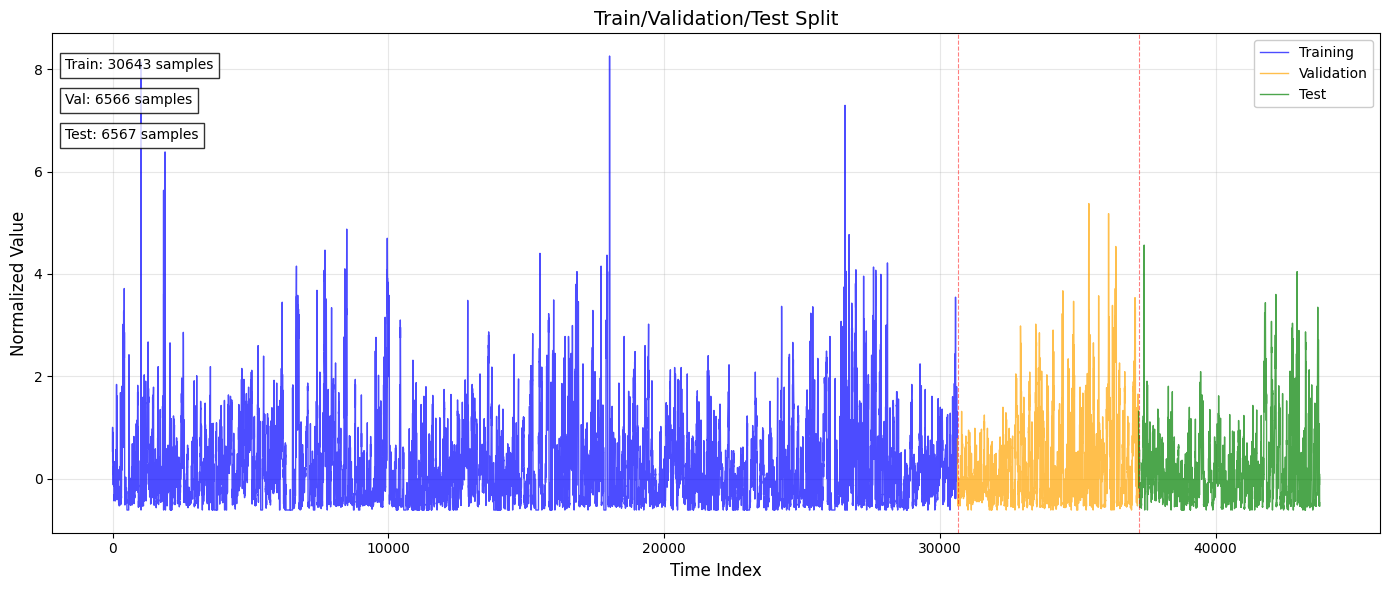

In [53]:
plot_data_split(
    univariate_data['X_train'], 
    univariate_data['X_val'], 
    univariate_data['X_test']
)

In [54]:
import mlflow
import mlflow.keras
from mlflow.models.signature import infer_signature
import matplotlib.pyplot as plt

def log_to_dagshub(
    model,
    architecture,
    model_type,
    X_test,
    y_test,
    scaler,
    preprocessing_info,
    n_future=12,
    experiment_name="proyecto-modelos-regresion"
):
    """
    Enhanced MLflow logging.
    
    Args:
        model: Trained Keras model (MLP/CNN/LSTM/ConvLSTM)
        model_type: Model type identifier ('mlp', 'cnn', 'lstm', 'convlstm')
        X_test: Test features (properly reshaped for model_type)
        y_test: Test targets
        scaler: Fitted scaler object
        preprocessing_info: Dict from preprocess_univariate_series()
        n_future: Prediction horizon length
        experiment_name: Existing experiment name from your notebook
    """
    # Use existing tracking setup
    with mlflow.start_run(run_name=f"{model_type}-{architecture}"):
        # ===== 1. Log Core Parameters =====
        mlflow.log_params({
            "model_type": model_type,
            "n_past": preprocessing_info['input_shapes'][model_type][0],
            "n_future": n_future,
            "scaler": str(scaler.__class__.__name__),
            "differencing": preprocessing_info.get("differenced", False),
            "train_samples": len(preprocessing_info['X_train']),
            "test_samples": len(X_test)
        })
        
        # ===== 2. Model Evaluation =====
        # Predict and calculate metrics
        y_pred = model.predict(X_test)
        
        if scaler:
            y_test_actual = scaler.inverse_transform(y_test.reshape(-1, n_future))
            y_pred_actual = scaler.inverse_transform(y_pred.reshape(-1, n_future))
        else:
            y_test_actual = y_test
            y_pred_actual = y_pred
        
        metrics = {
            'MSE': mean_squared_error(y_test_actual, y_pred_actual),
            'MAPE': mean_absolute_percentage_error(y_test_actual, y_pred_actual),
            'R2': r2_score(y_test_actual, y_pred_actual)
        }
        mlflow.log_metrics(metrics)
        
        # ===== 3. Model Logging =====
        # Add input/output signature
        signature = infer_signature(X_test, y_pred)
        mlflow.keras.log_model(
            model=model,
            artifact_path=f"{model_type}_model",
            signature=signature,
            registered_model_name=f"aqi_{model_type}_{architecture}"
        )
        
        # ===== 5. Visualization =====
        # Create and save prediction plot
        plt.figure(figsize=(12, 6))
        plt.plot(y_test_actual[:100].flatten(), label='Actual', alpha=0.7)
        plt.plot(y_pred_actual[:100].flatten(), label='Predicted', linestyle='--')
        plt.title(f"{model_type.upper()} Predictions (First 100 Samples)")
        plt.xlabel("Time Steps")
        plt.ylabel("AQI Value")
        plt.legend()
        
        plot_path = f"{model_type}_predictions.png"
        plt.savefig(plot_path, bbox_inches='tight', dpi=300)
        mlflow.log_artifact(plot_path)
        plt.close()
        
        # ===== 6. Tagging =====
        mlflow.set_tag("project", "proyecto-modelos")
        mlflow.set_tag("task", "time_series_forecasting")
        mlflow.set_tag("data_type", "AQI")
        
        print(f"""\n✅ Successfully logged {model_type} to DagsHub:
        - Run ID: {mlflow.active_run().info.run_id}
        - Metrics: {metrics}
        - Model URI: runs:/{mlflow.active_run().info.run_id}/{model_type}_model
        """)

#### MLP

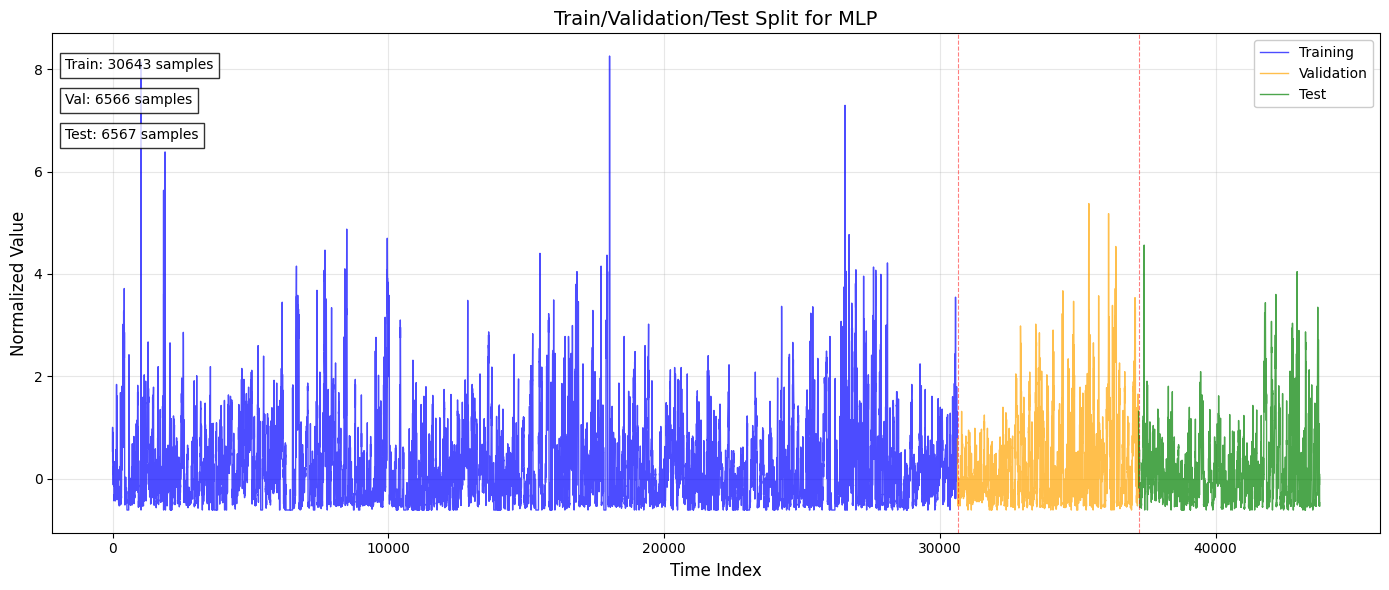

In [55]:
plot_data_split(univariate_data['X_train_mlp'], 
                univariate_data['X_val_mlp'], 
                univariate_data['X_test_mlp'],
                title='Train/Validation/Test Split for MLP')

In [56]:
X_train_mlp = univariate_data['X_train_mlp']
X_val_mlp = univariate_data['X_val_mlp']
X_test_mlp = univariate_data['X_test_mlp']
y_train = univariate_data['y_train']
y_val = univariate_data['y_val']
y_test = univariate_data['y_test']
X_test_mlp.shape, X_val_mlp.shape, X_train_mlp.shape, y_train.shape, y_val.shape, y_test.shape

((6567, 24), (6566, 24), (30643, 24), (30643, 1), (6566, 1), (6567, 1))

In [57]:
def build_train_mlps(X_train, y_train, X_val, y_val, n_future=1, epochs=50, batch_size=32):
    """
    Builds, trains, and evaluates 3 MLP architectures for time series forecasting.
    
    Args:
        X_train, y_train: Training data (from `preprocess_univariate_series`).
        X_val, y_val: Validation data.
        n_future (int): Number of steps to predict.
        epochs (int): Training epochs.
        batch_size (int): Batch size.
    
    Returns:
        Dict: Trained models and their histories.
    """
    input_shape = X_train.shape[1]
    
    # --- Architecture 1: Simple Shallow MLP ---
    model_shallow = Sequential([
        Dense(64, activation='relu', input_shape=(input_shape,)),
        Dense(n_future)
    ])
    model_shallow.compile(optimizer=Adam(), loss='mse')
    
    # --- Architecture 2: Deep MLP with Dropout ---
    model_deep = Sequential([
        Dense(128, activation='relu', input_shape=(input_shape,)),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(n_future)
    ])
    model_deep.compile(optimizer=Adam(), loss='mse')
    
    # --- Architecture 3: Wide MLP with BatchNorm ---
    model_wide = Sequential([
        Dense(256, activation='relu', input_shape=(input_shape,)),
        BatchNormalization(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dense(n_future)
    ])
    model_wide.compile(optimizer=Adam(), loss='mse')
    
    # Train all models
    print("Training Shallow MLP...")
    history_shallow = model_shallow.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        verbose=0
    )
    
    print("Training Deep MLP...")
    history_deep = model_deep.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        verbose=0
    )
    
    print("Training Wide MLP...")
    history_wide = model_wide.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        verbose=0
    )
    
    return {
        'models': {
            'shallow': model_shallow,
            'deep': model_deep,
            'wide': model_wide
        },
        'histories': {
            'shallow': history_shallow,
            'deep': history_deep,
            'wide': history_wide
        }
    }

def evaluate_model(
    model, 
    X_test, 
    y_test, 
    model_type='mlp', 
    scaler=None, 
    n_future=1,
    plot_samples=100
):
    """
    Evaluates a trained model on test data and plots predictions.
    
    Args:
        model: Trained Keras model (MLP/CNN/LSTM/ConvLSTM).
        X_test (np.ndarray): Test features.
        y_test (np.ndarray): Test targets.
        model_type (str): One of 'mlp', 'cnn', 'lstm', 'convlstm'.
        scaler: Scaler object (for inverse transformation).
        n_future (int): Forecast horizon.
        plot_samples (int): Number of samples to plot.
    
    Returns:
        dict: Metrics {'MSE': float, 'MAPE': float, 'R²': float}.
    """
    # Reshape X_test based on model type
    if model_type == 'mlp':
        X_test_reshaped = X_test  # (samples, n_past)
    elif model_type == 'cnn':
        X_test_reshaped = X_test.reshape(-1, X_test.shape[1], 1)  # (samples, n_past, 1)
    elif model_type == 'lstm':
        X_test_reshaped = X_test.reshape(-1, X_test.shape[1], 1)  # (samples, n_past, 1)
    elif model_type == 'convlstm':
        X_test_reshaped = X_test.reshape(-1, 1, X_test.shape[1], 1)  # (samples, 1, n_past, 1)
    else:
        raise ValueError("model_type must be one of: 'mlp', 'cnn', 'lstm', 'convlstm'")

    # Predict
    y_pred = model.predict(X_test_reshaped)
    
    # Inverse transform if scaler provided
    if scaler is not None:
        y_test_actual = scaler.inverse_transform(y_test.reshape(-1, n_future))
        y_pred_actual = scaler.inverse_transform(y_pred.reshape(-1, n_future))
    else:
        y_test_actual = y_test
        y_pred_actual = y_pred
    
    # Calculate metrics
    metrics = {
        'MSE': mean_squared_error(y_test_actual, y_pred_actual),
        'MAPE': mean_absolute_percentage_error(y_test_actual, y_pred_actual),
        'R²': r2_score(y_test_actual, y_pred_actual)
    }
    
    # Plot first `plot_samples` predictions vs true values
    plt.figure(figsize=(15, 5))
    plt.plot(y_test_actual[:plot_samples], label='True', alpha=0.7)
    plt.plot(y_pred_actual[:plot_samples], label='Predicted', linestyle='--')
    plt.title(f"{model_type.upper()} Predictions vs True (MSE={metrics['MSE']:.2f}, MAPE={metrics['MAPE']:.2f}), R²={metrics['R²']:.2f}")
    plt.legend()
    plt.show()
    
    return metrics

In [58]:
results_mlp = build_train_mlps(
    X_train_mlp, 
    y_train, 
    X_val_mlp, 
    y_val,
    n_future=n_future,
    epochs=30,
    batch_size=32
)

/Users/erick/Library/CloudStorage/OneDrive-ITESO/Modelos/proyecto-modelos/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training Shallow MLP...
Training Deep MLP...
Training Wide MLP...


206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 299us/step


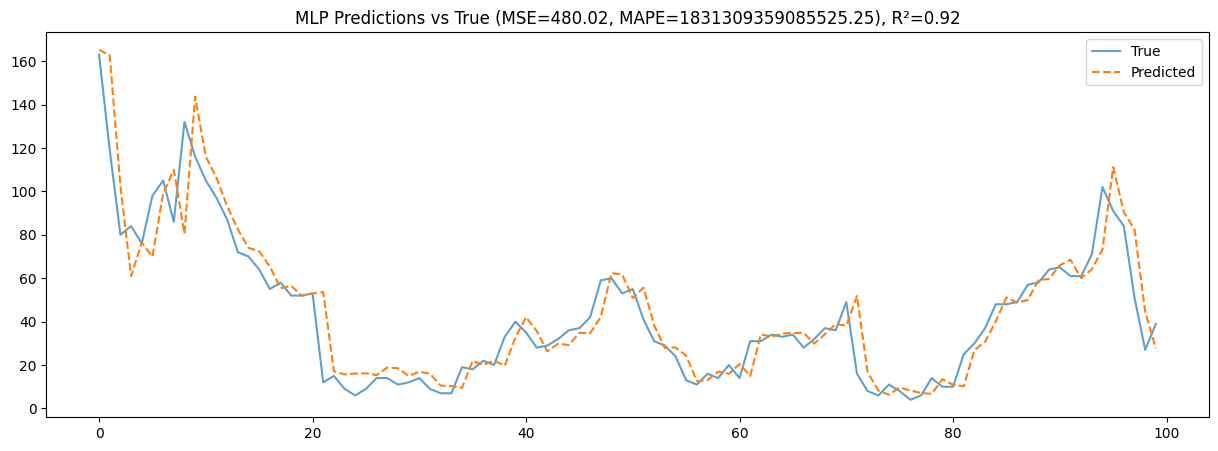

In [59]:
mlp_shallow_metrics = evaluate_model(
    model=results_mlp['models']['shallow'], 
    X_test=X_test_mlp, 
    y_test=y_test,
    model_type='mlp', 
    scaler=univariate_data['scaler'],
    n_future=n_future
)

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step


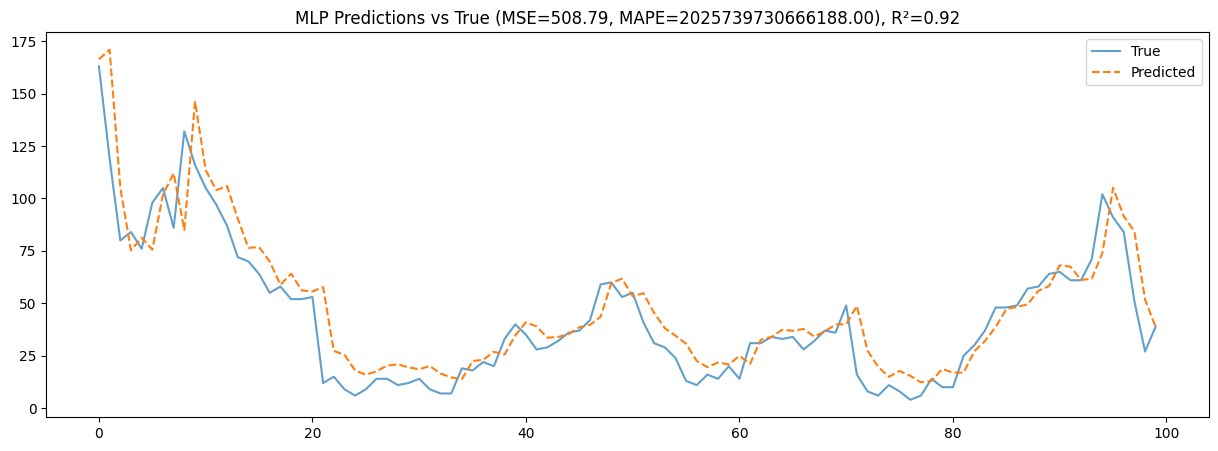

In [60]:
mlp_deep_metrics = evaluate_model(
    model=results_mlp['models']['deep'], 
    X_test=X_test_mlp, 
    y_test=y_test,
    model_type='mlp', 
    scaler=univariate_data['scaler'],
    n_future=n_future
)

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step


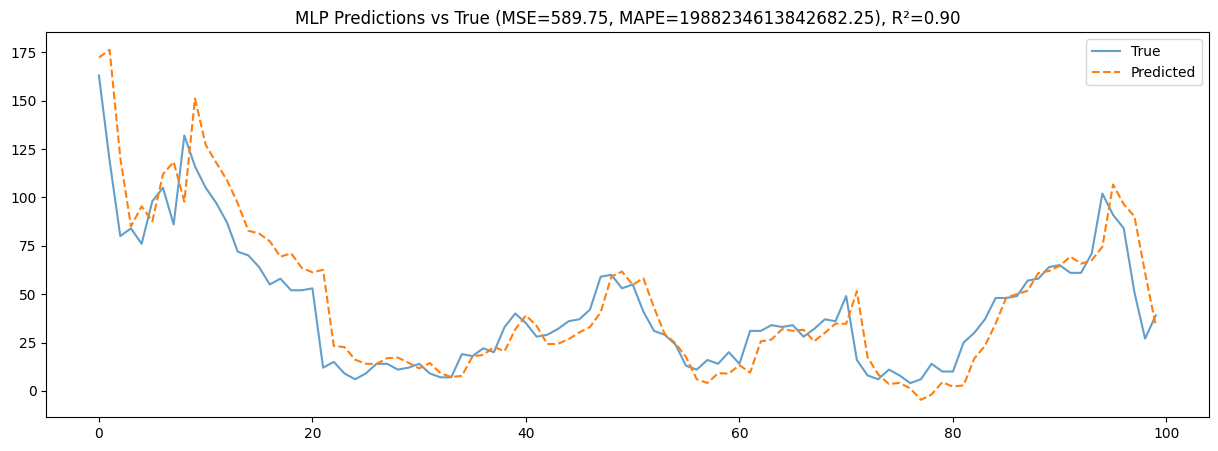

In [61]:
mlp_wide_metrics = evaluate_model(
    model=results_mlp['models']['wide'], 
    X_test=X_test_mlp, 
    y_test=y_test,
    model_type='mlp', 
    scaler=univariate_data['scaler'],
    n_future=n_future
)

In [62]:
log_to_dagshub(
    model=results_mlp['models']['shallow'],
    architecture="shallow",
    model_type="mlp",
    X_test=X_test_mlp,
    y_test=y_test,
    scaler=univariate_data['scaler'],
    preprocessing_info=univariate_data,
    n_future=n_future
)

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step


Successfully registered model 'aqi_mlp_shallow'.
2025/05/13 13:33:39 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: aqi_mlp_shallow, version 1
Created version '1' of model 'aqi_mlp_shallow'.



✅ Successfully logged mlp to DagsHub:
        - Run ID: 783c71669d6d4c1099aecab6e84e1d4a
        - Metrics: {'MSE': 480.01941902762513, 'MAPE': 1831309359085525.2, 'R2': 0.9225463951404652}
        - Model URI: runs:/783c71669d6d4c1099aecab6e84e1d4a/mlp_model
        
🏃 View run mlp-shallow at: https://dagshub.com/daduke1/proyecto-modelos.mlflow/#/experiments/2/runs/783c71669d6d4c1099aecab6e84e1d4a
🧪 View experiment at: https://dagshub.com/daduke1/proyecto-modelos.mlflow/#/experiments/2


In [63]:
log_to_dagshub(
    model=results_mlp['models']['deep'],
    architecture="deep",
    model_type="mlp",
    X_test=X_test_mlp,
    y_test=y_test,
    scaler=univariate_data['scaler'],
    preprocessing_info=univariate_data,
    n_future=n_future
)

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step


Successfully registered model 'aqi_mlp_deep'.
2025/05/13 13:33:56 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: aqi_mlp_deep, version 1
Created version '1' of model 'aqi_mlp_deep'.



✅ Successfully logged mlp to DagsHub:
        - Run ID: 78a77457898543b19a273dee9ade27c9
        - Metrics: {'MSE': 508.7896114089148, 'MAPE': 2025739730666188.0, 'R2': 0.917904176463256}
        - Model URI: runs:/78a77457898543b19a273dee9ade27c9/mlp_model
        
🏃 View run mlp-deep at: https://dagshub.com/daduke1/proyecto-modelos.mlflow/#/experiments/2/runs/78a77457898543b19a273dee9ade27c9
🧪 View experiment at: https://dagshub.com/daduke1/proyecto-modelos.mlflow/#/experiments/2


In [64]:
log_to_dagshub(
    model=results_mlp['models']['wide'],
    architecture="wide",
    model_type="mlp",
    X_test=X_test_mlp,
    y_test=y_test,
    scaler=univariate_data['scaler'],
    preprocessing_info=univariate_data,
    n_future=n_future
)

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step


Successfully registered model 'aqi_mlp_wide'.
2025/05/13 13:34:17 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: aqi_mlp_wide, version 1
Created version '1' of model 'aqi_mlp_wide'.



✅ Successfully logged mlp to DagsHub:
        - Run ID: 2b9a8defdc244834aeb0cf932f556251
        - Metrics: {'MSE': 589.7531930523986, 'MAPE': 1988234613842682.2, 'R2': 0.9048402856870659}
        - Model URI: runs:/2b9a8defdc244834aeb0cf932f556251/mlp_model
        
🏃 View run mlp-wide at: https://dagshub.com/daduke1/proyecto-modelos.mlflow/#/experiments/2/runs/2b9a8defdc244834aeb0cf932f556251
🧪 View experiment at: https://dagshub.com/daduke1/proyecto-modelos.mlflow/#/experiments/2


#### CNN